# **Decision Tree Model (ID3 Algorithm)**

Importing Libraries

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

Step 1: Loading & Basic cleaning

In [56]:
df = pd.read_csv("DatasetofDiabetes.csv")

df = df.drop(["ID", "No_Pation"], axis=1, errors="ignore")
df = df.drop_duplicates()
print(f"Rows after dropping duplicates: {df.shape[0]}")


numeric_cols = [ 'Urea', 'Cr', 'HbA1c', 'Chol',
                'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
feature_cols = numeric_cols + ['AGE'+'Gender']


Rows after dropping duplicates: 831


Step 2: Outlier Handling (IQR + median)

In [57]:
print("\n" + "=" * 70)
print("OUTLIER HANDLING (IQR + Median Replacement)")
print("=" * 70)

total_outliers = 0
for col in numeric_cols:
    if col not in df.columns:
        print(f"Skipping missing numeric column: {col}")
        continue

    df[col] = pd.to_numeric(df[col], errors='coerce')
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    median = df[col].median()

    outlier_mask = (df[col] < lower) | (df[col] > upper)
    outlier_count = int(outlier_mask.sum())
    total_outliers += outlier_count

    df.loc[outlier_mask, col] = median
    print(f"{col:<6}: {outlier_count:3d} outliers replaced with median = {median}")

print(f"\nTotal outliers replaced across numeric columns: {total_outliers}")


OUTLIER HANDLING (IQR + Median Replacement)
Urea  :  57 outliers replaced with median = 4.6
Cr    :  46 outliers replaced with median = 59.0
HbA1c :   5 outliers replaced with median = 8.1
Chol  :  23 outliers replaced with median = 4.8
TG    :  36 outliers replaced with median = 2.0
HDL   :  42 outliers replaced with median = 1.1
LDL   :   7 outliers replaced with median = 2.5
VLDL  :  57 outliers replaced with median = 1.0
BMI   :   2 outliers replaced with median = 30.0

Total outliers replaced across numeric columns: 275


Step 3: Target (Class) Preprocessing:  N,P,Y  →  0,1,2

In [58]:
df['CLASS'] = df['CLASS'].astype(str).str.strip().str.upper()
label_map = {'N': 0, 'P': 1, 'Y': 2}
y = df['CLASS'].map(label_map)
y = y.astype(int)

print("Class counts:")
print(y.value_counts())

Class counts:
CLASS
2    695
0     96
1     40
Name: count, dtype: int64


Step 4: Gender Preprocessing: M,F  →  1,0

In [59]:
df['Gender'] = df['Gender'].astype(str).str.strip().str.upper()
df['Gender'] = df['Gender'].map({'M': 1, 'F': 0})

print(df['Gender'].value_counts(dropna=False))

Gender
1    467
0    364
Name: count, dtype: int64


Step 5: Feature Importance (Correlation with Class)

In [60]:
df_corr = df.copy()
df_corr['CLASS_NUM'] = y  # numeric target

corr = df_corr[numeric_cols + ['CLASS_NUM']].corr()
feat_corr = corr['CLASS_NUM'].sort_values(ascending=False)
print(feat_corr)

CLASS_NUM    1.000000
BMI          0.585455
HbA1c        0.556327
TG           0.247660
VLDL         0.221828
Chol         0.204070
Urea         0.074257
HDL          0.019839
Cr           0.007612
LDL         -0.012883
Name: CLASS_NUM, dtype: float64


Step 6: Discretization of numeric features using scientific ranges

In [61]:

def apply_scientific_discretization(df):
    df = df.copy()

    # AGE
    df['AGE_bin'] = pd.cut(
        df['AGE'],
        bins=[0, 20, 35, 50, 65, 200],
        labels=['adolescent', 'young_adult', 'mid_age', 'senior', 'elderly']
    )

    # Urea
    df['Urea_bin'] = pd.cut(
        df['Urea'],
        bins=[0, 2.5, 7.1, 15, 100],
        labels=['low', 'normal', 'high', 'critical']
    )

    # Creatinine
    df['Cr_bin'] = pd.cut(
        df['Cr'],
        bins=[0, 50, 80, 120, 1000],
        labels=['low', 'normal', 'high', 'critical']
    )

    # HbA1c
    df['HbA1c_bin'] = pd.cut(
        df['HbA1c'],
        bins=[0, 5.7, 6.4, 20],
        labels=['normal', 'prediabetes', 'diabetes']
    )

    # Cholesterol
    df['Chol_bin'] = pd.cut(
        df['Chol'],
        bins=[0, 5.2, 6.2, 20],
        labels=['desirable', 'borderline', 'high']
    )

    # Triglycerides
    df['TG_bin'] = pd.cut(
        df['TG'],
        bins=[0, 1.7, 2.2, 20],
        labels=['normal', 'borderline', 'high']
    )

    # HDL
    df['HDL_bin'] = pd.cut(
        df['HDL'],
        bins=[0, 1.0, 1.5, 20],
        labels=['low', 'normal', 'protective']
    )

    # LDL
    df['LDL_bin'] = pd.cut(
        df['LDL'],
        bins=[0, 2.6, 3.3, 4.1, 20],
        labels=['optimal', 'near_optimal', 'borderline', 'high']
    )

    # VLDL
    df['VLDL_bin'] = pd.cut(
        df['VLDL'],
        bins=[0, 0.5, 1.0, 2.0, 100],
        labels=['low', 'normal', 'elevated', 'high']
    )

    # BMI
    df['BMI_bin'] = pd.cut(
        df['BMI'],
        bins=[0, 18.5, 25, 30, 35, 40, 200],
        labels=['underweight', 'normal', 'overweight', 'obese_I', 'obese_II', 'obese_III']
    )

    return df

df_discrete = apply_scientific_discretization(df)
df_discrete = df_discrete.dropna()
df_discrete


,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,...,AGE_bin,Urea_bin,Cr_bin,HbA1c_bin,Chol_bin,TG_bin,HDL_bin,LDL_bin,VLDL_bin,BMI_bin
0,0,50,4.7,46,4.9,4.2,0.9,1.1,1.4,0.5,...,mid_age,normal,low,normal,desirable,normal,normal,optimal,low,normal
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,...,young_adult,normal,normal,normal,desirable,normal,normal,optimal,normal,normal
4,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,...,young_adult,normal,low,normal,desirable,normal,low,optimal,low,normal
5,0,45,2.3,24,4.0,2.9,1.0,1.0,1.5,0.4,...,mid_age,low,low,normal,desirable,normal,low,optimal,low,normal
6,0,50,2.0,50,4.0,3.6,1.3,0.9,2.1,0.6,...,mid_age,low,low,normal,desirable,normal,low,optimal,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,71,4.6,97,7.0,7.5,1.7,1.2,1.8,0.6,...,elderly,normal,high,diabetes,high,normal,normal,optimal,normal,overweight
996,1,31,3.0,60,12.3,4.1,2.2,0.7,2.4,1.0,...,young_adult,normal,normal,diabetes,desirable,borderline,low,optimal,normal,obese_II
997,1,30,7.1,81,6.7,4.1,1.1,1.2,2.4,1.0,...,young_adult,normal,high,diabetes,desirable,normal,normal,optimal,normal,overweight
998,1,38,5.8,59,6.7,5.3,2.0,1.6,2.9,1.0,...,mid_age,normal,normal,diabetes,borderline,borderline,protective,near_optimal,normal,obese_III


Step 7: Encoding new discrete columns

In [62]:
df_enc = df_discrete.copy()
encoders = {}

categorical_columns = [
    'AGE_bin','Urea_bin','Cr_bin','HbA1c_bin','Chol_bin','TG_bin',
    'HDL_bin','LDL_bin','VLDL_bin','BMI_bin','Gender','CLASS'
]

for col in categorical_columns:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    encoders[col] = le



Step 8: Feature Selection

In [63]:
X = df_enc[
    ['AGE_bin','Urea_bin','Cr_bin','HbA1c_bin','Chol_bin',
     'TG_bin','HDL_bin','LDL_bin','VLDL_bin','BMI_bin']
]

y = df_enc['CLASS']

Step 9: Train/Test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nData sizes:")
print("Training:", len(X_train))
print("Testing :", len(X_test))


Data sizes:
Training: 664
Testing : 167


Step 10: Training and Evaluating

In [65]:
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    random_state=42
)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [66]:
print("Accuracy:", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=["Actual 0", "Actual 1", "Actual 2"],
                     columns=["Pred 0", "Pred 1", "Pred 2"])
print("\nConfusion Matrix:")
print(cm_df)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoders['CLASS'].classes_))

print("Train vs Test Accuracies")
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print(train_acc, test_acc)


print("\nCross Validation folds:")

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    clf,
    X,
    y,
    cv=cv,
    scoring='accuracy'
)

print(scores)
print("Mean Accuracy:", scores.mean())



Accuracy: 0.9760479041916168

Confusion Matrix:
          Pred 0  Pred 1  Pred 2
Actual 0      22       0       1
Actual 1       0       7       0
Actual 2       2       1     134

Classification Report:
              precision    recall  f1-score   support

           N       0.92      0.96      0.94        23
           P       0.88      1.00      0.93         7
           Y       0.99      0.98      0.99       137

    accuracy                           0.98       167
   macro avg       0.93      0.98      0.95       167
weighted avg       0.98      0.98      0.98       167

Train vs Test Accuracies
0.9608433734939759 0.9760479041916168

Cross Validation folds:
[0.9760479  0.96385542 0.93975904 0.96385542 0.95180723]
Mean Accuracy: 0.9590650025250703


Plot

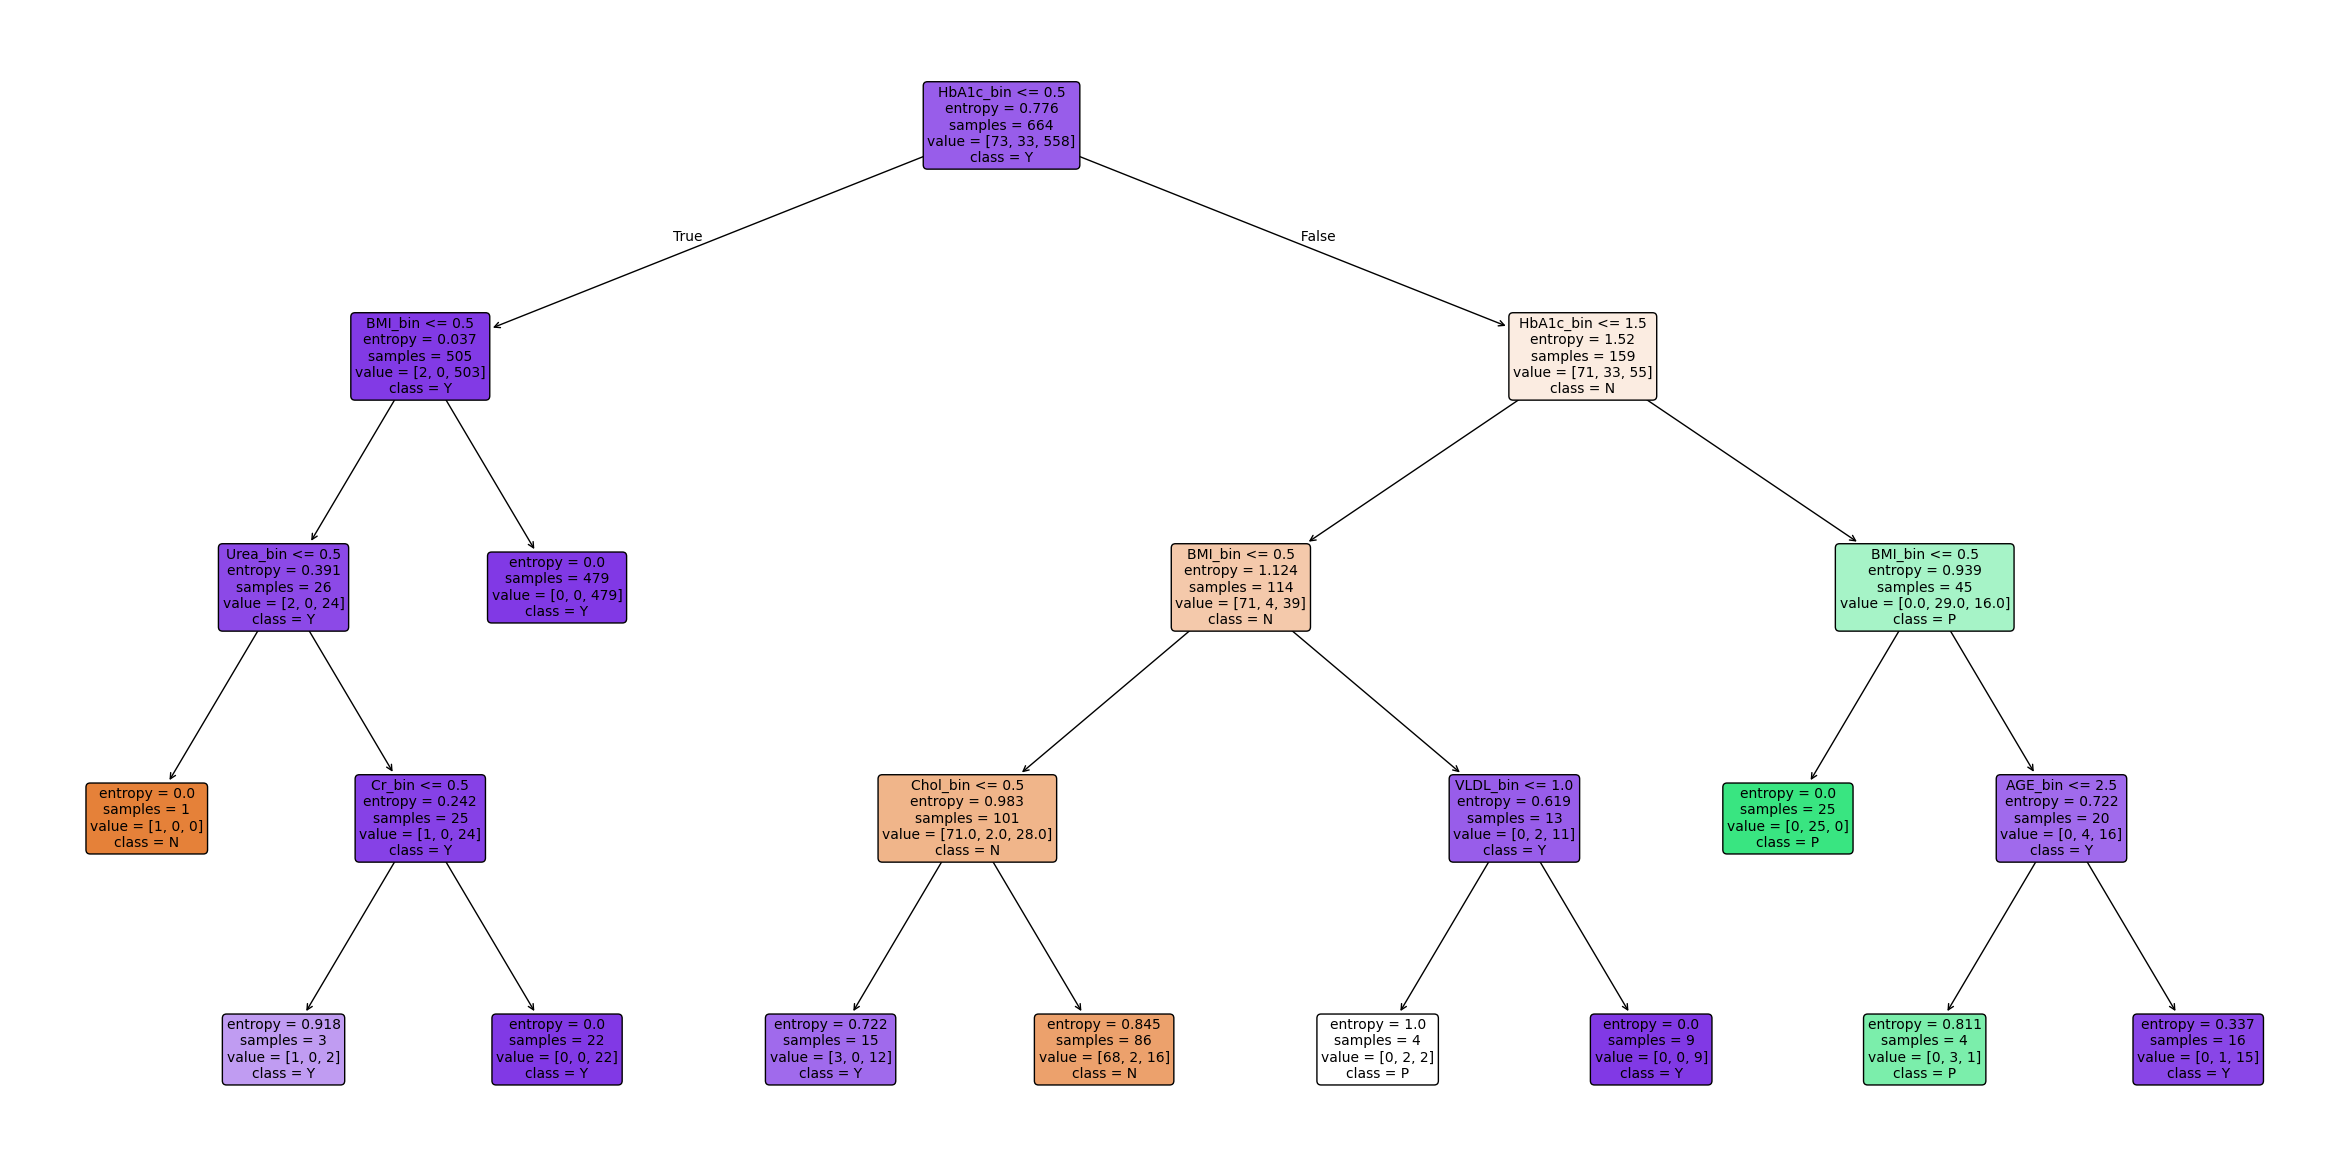

In [67]:

plt.figure(figsize=(30, 15))
plot_tree(
    clf,
    feature_names=X_train.columns.tolist(),
    class_names=['N', 'P', 'Y'],
    filled=True,
    rounded=True,
    fontsize=10
)

plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()
